# [1] 코호트 분석

In [20]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [21]:
path = '/content/drive/MyDrive/새싹2기/python_DA/data/'

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install koreanize_matplotlib
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 43.2 MB/s eta 0:00:00


In [23]:
df = pd.read_csv(path + 'rocket_sample_cohort.csv')

In [24]:
df.head()

,user_id,event_date,event_name
0,rk_0001,2024-01-30,visit
1,rk_0001,2024-01-30,view_item
2,rk_0001,2024-01-30,add_to_cart
3,rk_0001,2024-01-10,visit
4,rk_0001,2024-01-10,view_item


In [25]:
df['user_id'].nunique()

2000

In [26]:
df['event_name'].value_counts()

,count
event_name,
visit,8998
view_item,6497
add_to_cart,3767
begin_checkout,1165
purchase,556


In [27]:
# 자료형 datetime으로 변경후 재할당
df['event_date'] = pd.to_datetime(df['event_date'])

In [28]:
df.dtypes

,0
user_id,object
event_date,datetime64[ns]
event_name,object


In [29]:
df['event_name'].describe()

,event_name
count,20983
unique,5
top,visit
freq,8998


In [30]:
df['event_date'].min(), df['event_date'].max()

(Timestamp('2024-01-02 00:00:00'), Timestamp('2024-06-29 00:00:00'))

## (1) 코호트 할당

In [31]:
df.groupby('user_id')['event_date'].min()

,event_date
user_id,
rk_0001,2024-01-10
rk_0002,2024-01-14
rk_0003,2024-02-10
rk_0004,2024-02-02
rk_0005,2024-02-13
...,...
rk_1996,2024-04-02
rk_1997,2024-04-02
rk_1998,2024-05-31


In [34]:
# transform -> 원본에 이어 붙일 수 있다.
df['cohort_date'] = df.groupby('user_id')['event_date'].transform('min')

In [35]:
df['cohort_month'] = df['cohort_date'].dt.to_period('M')
df['event_month'] = df['event_date'].dt.to_period('M')

In [49]:
df.tail()

,user_id,event_date,event_name,cohort_date,cohort_month,event_month,period
20978,rk_2000,2024-05-27,visit,2024-03-31,2024-03,2024-05,2
20979,rk_2000,2024-05-27,view_item,2024-03-31,2024-03,2024-05,2
20980,rk_2000,2024-06-21,visit,2024-03-31,2024-03,2024-06,3
20981,rk_2000,2024-06-21,view_item,2024-03-31,2024-03,2024-06,3
20982,rk_2000,2024-06-21,add_to_cart,2024-03-31,2024-03,2024-06,3


In [38]:
df['cohort_month'].value_counts()

,count
cohort_month,
2024-03,7562
2024-02,5778
2024-04,3567
2024-01,3180
2024-05,644
2024-06,252


## (2) 기간 계산

In [44]:
df['period'] = (df['event_month'] - df['cohort_month']).apply(lambda x:x.n)

In [46]:
df.tail()

,user_id,event_date,event_name,cohort_date,cohort_month,event_month,period
20978,rk_2000,2024-05-27,visit,2024-03-31,2024-03,2024-05,2
20979,rk_2000,2024-05-27,view_item,2024-03-31,2024-03,2024-05,2
20980,rk_2000,2024-06-21,visit,2024-03-31,2024-03,2024-06,3
20981,rk_2000,2024-06-21,view_item,2024-03-31,2024-03,2024-06,3
20982,rk_2000,2024-06-21,add_to_cart,2024-03-31,2024-03,2024-06,3


## (3) 코호트 테이블 생성 및 리텐션율 계산

In [50]:
cohort_table = df.groupby(['cohort_month', 'period'])['user_id'].nunique().unstack()
cohort_table

period,0,1,2,3,4,5
cohort_month,,,,,,
2024-01,244.0,142.0,139.0,134.0,145.0,136.0
2024-02,465.0,289.0,283.0,291.0,273.0,NaN
2024-03,692.0,432.0,456.0,435.0,NaN,NaN
2024-04,393.0,249.0,234.0,NaN,NaN,NaN
2024-05,127.0,58.0,NaN,NaN,NaN,NaN
2024-06,79.0,NaN,NaN,NaN,NaN,NaN


In [51]:
# 리텐션율 계tks
cohort_size = cohort_table[0]

In [52]:
cohort_size

,0
cohort_month,
2024-01,244.0
2024-02,465.0
2024-03,692.0
2024-04,393.0
2024-05,127.0
2024-06,79.0


<Axes: xlabel='cohort_month', ylabel='0'>

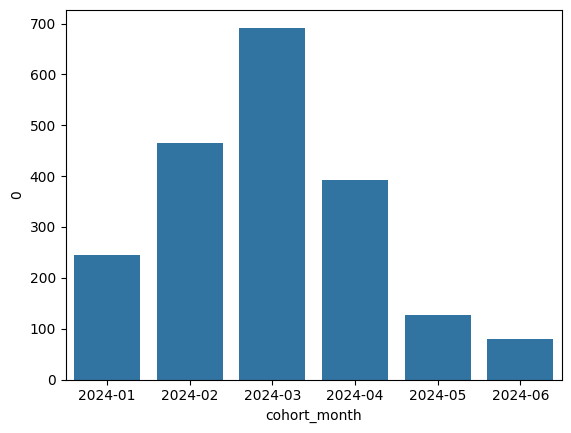

In [53]:
sns.barplot(cohort_size)

In [58]:
retention_table = cohort_table.divide(cohort_size, axis = 0).round(2)

Text(0.5, 1.0, '월별 코호트 리텐션')

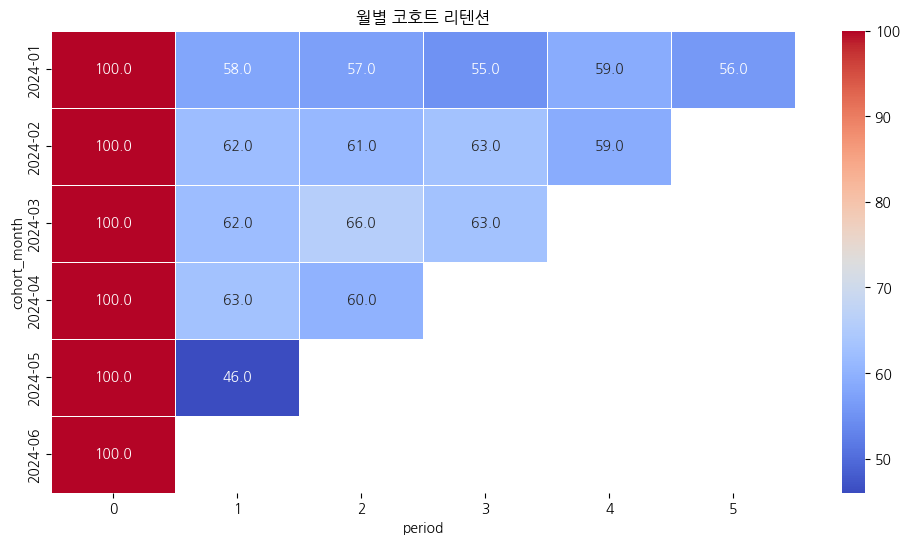

In [69]:
plt.figure(figsize = (12,6))
sns.heatmap(retention_table * 100, cmap= 'coolwarm', fmt = '.1f', annot=True, linewidths=0.5)
plt.title('월별 코호트 리텐션')

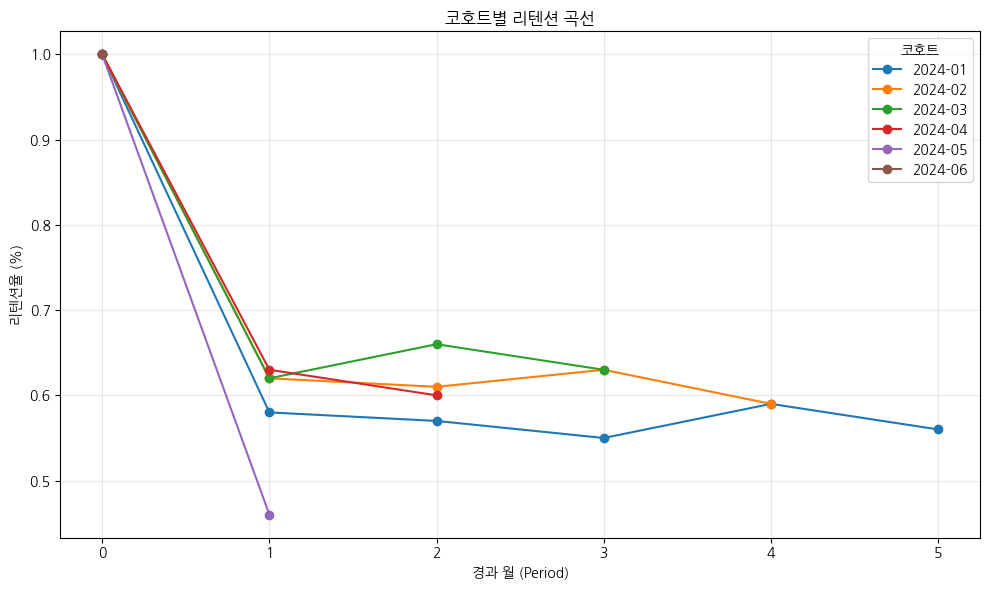

In [70]:
plt.figure(figsize=(10, 6))

for cohort in retention_table.index:
    data = retention_table.loc[cohort].dropna()
    plt.plot(data.index, data.values, marker='o', label=str(cohort))

plt.title('코호트별 리텐션 곡선')
plt.xlabel('경과 월 (Period)')
plt.ylabel('리텐션율 (%)')
plt.legend(title='코호트')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()